### ***hscode generate sampling***
---

In [1]:
!pip install yake
!pip install transformers
!pip install --upgrade diffusers transformers scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.8 MB/s eta 0:00:00


In [19]:
### import library
# import
from google.colab import drive
drive.mount("/content/drive")
import numpy as np
import pandas as pd
import re
import math
from multiprocessing import Pool
# nlp
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
import yake
nltk.download('punkt')
from tqdm import tqdm
kw_extractor = yake.KeywordExtractor()
# sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
from torch.nn import Sequential, Module
from PIL import Image
# from transformers import StableDiffusionPipeline
from matplotlib import pyplot as plt
from scipy.stats import norm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [78]:
### data import
path="/content/drive/MyDrive/DS5500_Project Capstone/dataset/main_dataset.csv"

# load dataset
df = pd.read_csv(path)
# df=df.sample(500)
df=df.dropna()

unique_code = list(set(df['HS_Code'].tolist()))
print(f"unique code number: ", len(set(unique_code)))

unique code number:  520


In [79]:
# 'Target' 열의 고유 값 출력
unique_values = df['HS_Code'].unique()

# select categories
counts = [df[df['HS_Code'] == i].shape[0] for i in unique_values]

# 가로로 출력
print(*counts, sep=', ')

44, 45, 45, 45, 38, 45, 45, 45, 45, 26, 45, 45, 45, 32, 45, 45, 43, 45, 15, 45, 34, 18, 45, 45, 79, 45, 14, 45, 24, 25, 45, 1, 45, 45, 8, 23, 1, 45, 21, 34, 5, 24, 45, 6, 2, 13, 31, 10, 32, 2, 45, 14, 45, 13, 45, 45, 8, 30, 7, 15, 18, 45, 45, 8, 6, 14, 28, 23, 45, 6, 45, 90, 2, 45, 23, 8, 45, 45, 45, 45, 6, 31, 8, 45, 45, 45, 45, 5, 24, 5, 45, 22, 45, 32, 6, 16, 45, 45, 45, 45, 45, 13, 45, 45, 6, 45, 45, 45, 45, 45, 39, 45, 26, 19, 45, 37, 45, 45, 44, 45, 45, 15, 6, 45, 25, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 20, 45, 1, 45, 2, 21, 7, 6, 10, 25, 45, 33, 34, 7, 45, 14, 45, 18, 14, 45, 18, 2, 1, 10, 45, 18, 45, 10, 45, 45, 18, 45, 60, 45, 45, 45, 41, 45, 45, 45, 45, 45, 45, 45, 45, 45, 38, 45, 27, 45, 45, 45, 45, 45, 35, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 41, 45, 5, 45, 45, 45, 45, 29, 45, 45, 45, 7, 26, 45, 6, 1, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 37, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 10, 38, 45, 45, 45, 6, 252, 205, 123, 123, 210, 205, 210, 207, 2

In [74]:
print(unique_values)

[500100 520819 520821 520822 520823 520829 520831 520832 520833 520839
 520841 520842 520843 520849 520851 520852 520859 520911 520912 520919
 520921 520922 520929 520931 520932 520939 520941 520942 520943 520949
 520951 520952 520959 521011 521019 521021 521029 521031 521032 521039
 521041 521049 521051 521059 521111 521112 521119 521120 521131 521132
 521139 521141 521142 521143 521149 521151 521152 521159 521211 521212
 521213 521214 521215 521221 521222 521223 521224 521225 530110 530121
 530129 530130 500300 500400 500500 500600 500710 500720 500790 510111
 510119 510121 510129 510130 510211 510219 510220 510310 510320 510330
 510400 510510 510521 510529 510539 510540 510610 510620 510710 510720
 510810 510820 510910 510990 511000 511111 511119 511120 511130 511190
 511211 511219 511220 511230 511290 511300 520100 520210 520291 520299
 520300 520411 520419 520420 520511 520512 520513 520514 520515 520521
 520522 520523 520524 520526 520527 520528 520531 520532 520533 520535
 52054

In [82]:
# code list
selected_codes = [500100, 520819, 520821, 520822]

# extract
df = df[df['HS_Code'].isin(selected_codes)]

# df
df.head()

,HS_Code,Description
0,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250
1,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250
2,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250
3,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250
4,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250


In [83]:
# select categories
counts = [df[df['HS_Code'] == i].shape[0] for i in selected_codes]

# print
print(*counts, sep=', ')

44, 45, 45, 45


In [84]:
### word imbedding & keywords
# create a hscode - keyword map
code_keyword_map = {}
for code in tqdm(unique_code):
    concat_description = " ".join(df[df['HS_Code'] == code]['Description'].tolist())
    keywords = kw_extractor.extract_keywords(concat_description)[:8]
    key_word_list = [i[0].lower() for i in keywords]
    code_keyword_map[code] = key_word_list

# save it to json
import json
# Saving the dictionary to a JSON file
with open('code_keyword_map.json', 'w') as file:
    json.dump(code_keyword_map, file)

print("Saved code_keyword_map to code_keyword_map.json")

100%|██████████| 520/520 [00:00<00:00, 661.97it/s]

Saved code_keyword_map to code_keyword_map.json


In [85]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def jaccard_similarity(sentence1, sentence2):
    # Tokenize the sentences into words
    set1 = set(sentence1.split())
    set2 = set(sentence2.split())

    # Calculate intersection and union
    intersection = set1.intersection(set2)
    union = set1.union(set2)

    # Compute Jaccard similarity
    jaccard = len(intersection) / len(union)

    return jaccard

def calculate_accuracy(list1, list2):
    # Ensure the two lists are of the same length
    if len(list1) != len(list2):
        raise ValueError("The two lists must have the same length")

    # Calculate the number of matches
    matching_elements = sum([i == j for i, j in zip(list1, list2)])

    # Calculate accuracy
    accuracy = matching_elements / len(list1)

    return accuracy

def calculate_cosine_similarity(sentence1, sentence2):
    # Create a CountVectorizer to count the word frequencies
    vectorizer = CountVectorizer()

    # Vectorize the sentences
    vectors = vectorizer.fit_transform([sentence1, sentence2]).toarray()

    # Calculate cosine similarity
    cos_sim = cosine_similarity(vectors[0].reshape(1, -1), vectors[1].reshape(1, -1))

    # Since cosine_similarity returns a matrix, we'll get the single value out
    return cos_sim[0][0]

In [86]:
import re

def clean(input_str):
    # Remove all numbers
    input_str = input_str.lower()
    input_str = re.sub(r'\d+', '', input_str)

    # Remove specific substrings
    patterns = ["hs", "h\.s\.", "code"]
    for pattern in patterns:
        input_str = re.sub(pattern, '', input_str, flags=re.IGNORECASE)

    # Return the modified string
    return input_str.strip()

# Example usage:
string = "This is a test string123 with hs, h.s., and code inside."
print(clean(string))

this is a test string with , , and  inside.


In [87]:
# you can use calculate_cosine_similarity or jaccard_similarity
df = df.dropna()
def find_most_matching_keyword(description, code_keyword_map):
    best_match = None
    max_similarity = 0
    for code, keyword_list in code_keyword_map.items():
        similarity = calculate_cosine_similarity(clean(description), " ".join(keyword_list))
        # print(distance, description.lower(), " ".join(keyword_list))
        if similarity > max_similarity:
            max_similarity = similarity
            best_match = code
    # print(f"Best: {code}, \n{' '.join(keyword_list)}, \n{description.lower()}\n")
    return best_match


# find top 5 best code by similarity metrics
def find_alternate_code(description, code_keyword_map):
    alternate = {}

    # Loop through each code and its associated keyword list
    for code, keyword_list in code_keyword_map.items():
        similarity = calculate_cosine_similarity(clean(description), " ".join(keyword_list))

        # If there's some similarity, add to the alternate dictionary
        if similarity > 0:
            alternate[code] = similarity

    # Sort the alternate dictionary by similarity scores in descending order and take the top 5
    sorted_alternate = dict(sorted(alternate.items(), key=lambda item: item[1], reverse=True)[:5])

    return sorted_alternate



# Apply the function to each row in the DataFrame
df['Prediction'] = df['Description'].apply(lambda x: find_most_matching_keyword(x, code_keyword_map))
df['KeyWord'] = df['HS_Code'].apply(lambda x: " ".join(code_keyword_map[x]) if not pd.isna(x) else None)
df['Prediction_Keyword'] = df['Prediction'].apply(lambda x: " ".join(code_keyword_map[x]) if not pd.isna(x) else None)
df['Alternate'] = df['Description'].apply(lambda x: find_alternate_code(x, code_keyword_map))

# only keep high confidence
# test_df = test_df[test_df['Alternate'].apply(lambda x: max(x.values()) >= 0.3)]
# drop na
# df = df.dropna()
# test_df = df.sample(100)

df.head()

,HS_Code,Description,Prediction,KeyWord,Prediction_Keyword,Alternate
0,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250,500100.0,brown jersey glove disconnectors suitable jers...,brown jersey glove disconnectors suitable jers...,{500100: 0.14907119849998599}
1,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250,500100.0,brown jersey glove disconnectors suitable jers...,brown jersey glove disconnectors suitable jers...,{500100: 0.14907119849998599}
2,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250,500100.0,brown jersey glove disconnectors suitable jers...,brown jersey glove disconnectors suitable jers...,{500100: 0.14907119849998599}
3,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250,500100.0,brown jersey glove disconnectors suitable jers...,brown jersey glove disconnectors suitable jers...,{500100: 0.14907119849998599}
4,500100,DISCONNECTORS SUITABLE FOR S3CD 362/1250,500100.0,brown jersey glove disconnectors suitable jers...,brown jersey glove disconnectors suitable jers...,{500100: 0.14907119849998599}


In [88]:
### import pre-trained stable diffusion model
import torch
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionPipeline

# model
model_id = "CompVis/stable-diffusion-v1-4"
# device = "cpu"
device = "cuda"

# pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

# generate
images=[]
for index, row in df.iterrows():
  description=row["KeyWord"]
  image=pipe(description).images[0]
  images.append(image)

print("num of images:",len(images))

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

num of images: 179


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

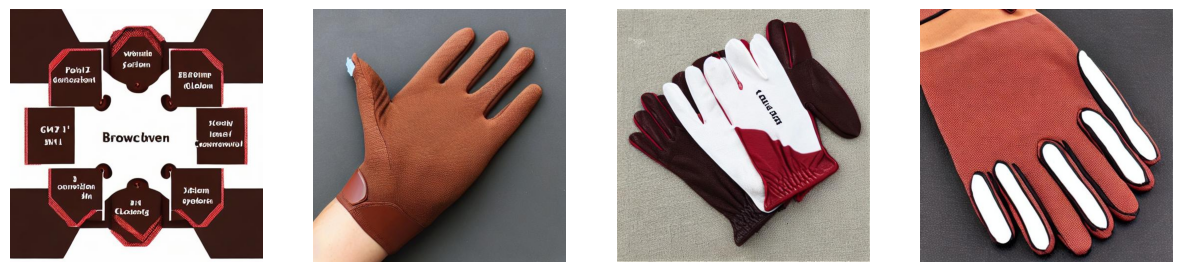

In [89]:
### samples example
# generate
image_samples=[]
for index, row in df[:4].iterrows():
  description=row["KeyWord"]
  image=pipe(description).images[0]
  # images.append(image)

  buffered = BytesIO()
  image.save(buffered, format="JPEG")
  img_str = buffered.getvalue()
  image_samples.append(img_str)
0
# image show
fig, axes = plt.subplots(1, len(image_samples), figsize=(15, 5))
for i, img_bytes in enumerate(image_samples):
    img = Image.open(BytesIO(img_bytes))
    axes[i].imshow(img)
    axes[i].axis('off')

plt.show()

### ***clip***

In [90]:
### clip model
"""SKIP THIS CODE"""
from transformers import CLIPProcessor, CLIPModel

# clip
model=CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# get similarities
batch_size=16
for description in df["KeyWord"]:
  for image_path in images:
    inputs=processor(text=[description],images=image,return_tensors="pt",padding=True)
    outputs=model(**inputs)
    logits_per_image=outputs.logits_per_image
    probs=logits_per_image.softmax(dim=1)

  print("Description: {}, Image: {}, Similarity: {}".format(description, image_path,probs[0][0].item()))

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Description: brown jersey glove disconnectors suitable jersey glove clute pattern straight thumb clute pattern straight cotton jersey glove beef plasma firbinogen beef plasma thrombin, Image: <PIL.Image.Image image mode=RGB size=512x512 at 0x7BFBFDCCACE0>, Similarity: 1.0
Description: brown jersey glove disconnectors suitable jersey glove clute pattern straight thumb clute pattern straight cotton jersey glove beef plasma firbinogen beef plasma thrombin, Image: <PIL.Image.Image image mode=RGB size=512x512 at 0x7BFBFDCCACE0>, Similarity: 1.0
Description: brown jersey glove disconnectors suitable jersey glove clute pattern straight thumb clute pattern straight cotton jersey glove beef plasma firbinogen beef plasma thrombin, Image: <PIL.Image.Image image mode=RGB size=512x512 at 0x7BFBFDCCACE0>, Similarity: 1.0
Description: brown jersey glove disconnectors suitable jersey glove clute pattern straight thumb clute pattern straight cotton jersey glove beef plasma firbinogen beef plasma thromb

KeyboardInterrupt: ignored

In [92]:
### extract feature(inputs)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# image, text feature list
image_features_list = []
text_features_list = []

# extract features
for i in range(0, len(df), batch_size):
    batch_texts = df["KeyWord"][i:i+batch_size].tolist()
    batch_images = images[i:i+batch_size]

    inputs = clip_processor(text=batch_texts, images=batch_images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = clip_model(**inputs)

    image_features = outputs.image_embeds
    text_features = outputs.text_embeds

    image_features_list.append(image_features)
    text_features_list.append(text_features)

# to tensor
image_features_tensor = torch.cat(image_features_list, dim=0)
text_features_tensor = torch.cat(text_features_list, dim=0)

print("Image features tensor shape:", image_features_tensor.shape)
print("Text features tensor shape:", text_features_tensor.shape)

Image features tensor shape: torch.Size([179, 512])
Text features tensor shape: torch.Size([179, 512])


### ***resnet***

In [124]:
### build dataset
"""connect image, text dataset"""
combined_features = torch.cat((image_features_tensor, text_features_tensor), dim=1)
combined_features_cpu = combined_features.cpu().numpy()
X = pd.DataFrame(combined_features_cpu)

# y
y = df['HS_Code'].reset_index(drop=True)

print("Combined feature tensor shape:", combined_features.shape)

Combined feature tensor shape: torch.Size([179, 1024])


In [125]:
### dataloader train & test
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim

# split
X_np = X
y_np = y.to_numpy()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_np)
X_train,X_test,y_train,y_test=train_test_split(X_np,y_encoded,test_size=0.2)

# NumPy 배열로 변환
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# to_tensor
train_data = torch.tensor(X_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.long)
test_data = torch.tensor(X_test, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_data = self.data[idx]
        sample_label = self.labels[idx]
        return sample_data, sample_label

# train
train_dataset=CustomDataset(train_data,train_labels)
train_data=DataLoader(dataset=train_dataset, batch_size=30, shuffle=True)

# test
test_dataset=CustomDataset(test_data,test_labels)
test_data=DataLoader(dataset=test_dataset,batch_size=30,shuffle=True)

# input_size check
data_sample, label_sample = next(iter(train_data))
input_size=data_sample.shape[1]
output_size=len(torch.unique(label_sample))

# labels
unique_labels_count = np.unique(y_train)
print(f"Unique labels in y_train: {len(unique_labels_count)}")

Unique labels in y_train: 4


In [113]:
### resnet
class ResidualSequence(Sequential):
    def forward(self, x):
        side_result = super().forward(x)
        final_result=x+side_result
        return final_result

In [114]:
input_size = input_size
hidden_dims = 64
fan_out_dims = 32
output_dims = len(np.unique(y_encoded))

class ClassificationNetwork(nn.Module):
    def __init__(self, input_size, hidden_dims, fan_out_dims, output_dims):
        super(ClassificationNetwork, self).__init__()

        # Main network with ResidualSequence blocks
        self.main = nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            nn.ReLU(),
            ResidualSequence(nn.Sequential(
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.BatchNorm1d(fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
                nn.BatchNorm1d(hidden_dims)
            )),
            ResidualSequence(nn.Sequential(
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.BatchNorm1d(fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
                nn.BatchNorm1d(hidden_dims)
            )),
            ResidualSequence(nn.Sequential(
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.BatchNorm1d(fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
                nn.BatchNorm1d(hidden_dims)
            )),
            ResidualSequence(nn.Sequential(
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.BatchNorm1d(fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
                nn.BatchNorm1d(hidden_dims)
            )),
            nn.Linear(hidden_dims, output_dims),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.main(x)

# Instantiate and use the model
model = ClassificationNetwork(input_size, hidden_dims, fan_out_dims, output_dims)
print(model)

ClassificationNetwork(
  (main): Sequential(
    (0): Linear(in_features=1024, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResidualSequence(
      (0): Sequential(
        (0): ReLU()
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=64, out_features=32, bias=True)
        (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Linear(in_features=32, out_features=64, bias=True)
        (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): ResidualSequence(
      (0): Sequential(
        (0): ReLU()
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=64, out_features=32, bias=True)
        (3): BatchNorm1d(32, eps=1e-05, momentum=0

In [115]:
### train
def train_model(model, train_loader, criterion, optimizer, epochs=301, test_every=10):
    # Store training statistics
    train_losses, train_accs, test_accs = [], [], []

    for epoch in range(epochs):
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

        if epoch % test_every == 0:
            train_outputs = model(train_data.dataset.data.float())
            _, train_preds = torch.max(train_outputs, 1)
            train_accuracy = (train_preds == train_data.dataset.labels).float().mean()
            print(f'Epoch {epoch}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}')
            train_losses.append(loss.item())
            train_accs.append(train_accuracy)

    return train_losses, train_accs

# Define the model, criterion, and optimizer
model = ClassificationNetwork(input_size, hidden_dims, fan_out_dims, output_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

# Train the model
train_losses, train_accs = train_model(model, train_data, criterion, optimizer)

Epoch 0, Loss: 0.75, Train Accuracy: 1.00
Epoch 10, Loss: 0.74, Train Accuracy: 1.00
Epoch 20, Loss: 0.74, Train Accuracy: 1.00
Epoch 30, Loss: 0.74, Train Accuracy: 1.00
Epoch 40, Loss: 0.74, Train Accuracy: 1.00
Epoch 50, Loss: 0.74, Train Accuracy: 1.00
Epoch 60, Loss: 0.74, Train Accuracy: 1.00
Epoch 70, Loss: 0.74, Train Accuracy: 1.00
Epoch 80, Loss: 0.74, Train Accuracy: 1.00
Epoch 90, Loss: 0.74, Train Accuracy: 1.00
Epoch 100, Loss: 0.74, Train Accuracy: 1.00
Epoch 110, Loss: 0.74, Train Accuracy: 1.00
Epoch 120, Loss: 0.74, Train Accuracy: 1.00
Epoch 130, Loss: 0.74, Train Accuracy: 1.00
Epoch 140, Loss: 0.74, Train Accuracy: 1.00
Epoch 150, Loss: 0.74, Train Accuracy: 1.00
Epoch 160, Loss: 0.74, Train Accuracy: 1.00
Epoch 170, Loss: 0.75, Train Accuracy: 1.00
Epoch 180, Loss: 0.76, Train Accuracy: 1.00
Epoch 190, Loss: 0.75, Train Accuracy: 1.00
Epoch 200, Loss: 0.75, Train Accuracy: 1.00
Epoch 210, Loss: 0.74, Train Accuracy: 1.00
Epoch 220, Loss: 0.74, Train Accuracy: 1.00

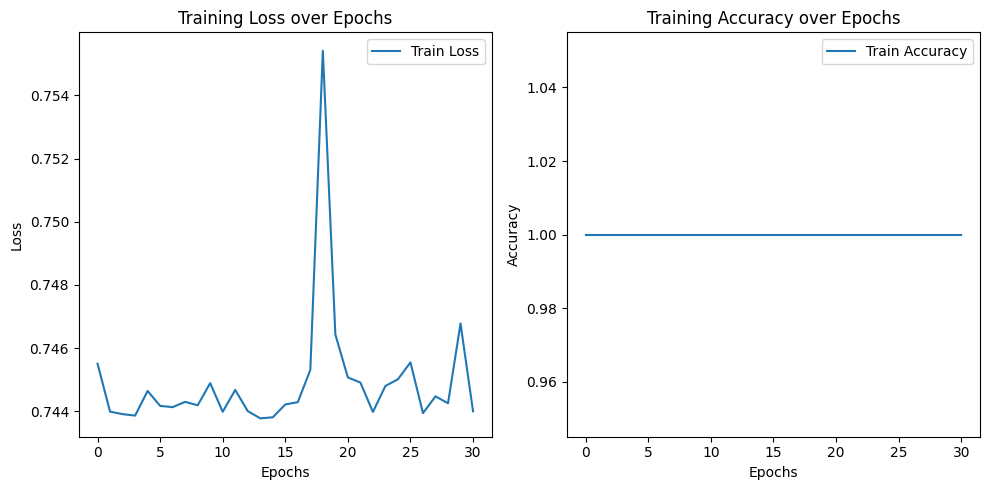

In [116]:
# 학습 손실 그래프
plt.figure(figsize=(10, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [117]:
### test_model
def test_model(model, test_loader, criterion):
    model.eval()

    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data.float())
            loss = criterion(outputs, labels.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    average_loss = total_loss / len(test_loader)
    accuracy = 100 * correct_predictions / total_predictions

    print(f'Test Loss: {average_loss:.2f}, Test Accuracy: {accuracy:.2f}%')

    return average_loss, accuracy

# 모델 테스트
test_loss, test_acc = test_model(model, test_data, criterion)

Test Loss: 0.74, Test Accuracy: 100.00%


In [126]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# 전체 데이터셋 준비
X_np = X_np.to_numpy()
X_np = X_np.reshape(X_np.shape[0], -1)
X_all = torch.tensor(X_np, dtype=torch.float32)
y_all = torch.tensor(y_encoded, dtype=torch.long)

# Stratified K-Fold 교차 검증 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 결과를 저장할 리스트
fold_accuracies = []

# 교차 검증 루프
for fold, (train_ids, test_ids) in enumerate(skf.split(X_np, y_encoded)):
    # 데이터셋 분할
    X_train_fold, X_test_fold = X_all[train_ids], X_all[test_ids]
    y_train_fold, y_test_fold = y_all[train_ids], y_all[test_ids]

    # DataLoader 준비
    train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), batch_size=30, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_fold, y_test_fold), batch_size=30)

    # 모델 초기화
    model = ClassificationNetwork(input_size, hidden_dims, fan_out_dims, output_dims)

    # 손실 함수와 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

    # 모델 훈련
    train_model(model, train_loader, criterion, optimizer, epochs=301, test_every=10)

    # 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    fold_accuracies.append(accuracy)
    print(f'Fold {fold}, Test Accuracy: {accuracy:.2f}')

# 평균 정확도 출력
avg_accuracy = np.mean(fold_accuracies)
print(f'Average Accuracy across folds: {avg_accuracy:.2f}')


Epoch 0, Loss: 0.74, Train Accuracy: 1.00
Epoch 10, Loss: 0.74, Train Accuracy: 1.00
Epoch 20, Loss: 0.75, Train Accuracy: 1.00
Epoch 30, Loss: 0.75, Train Accuracy: 1.00
Epoch 40, Loss: 0.74, Train Accuracy: 1.00
Epoch 50, Loss: 0.75, Train Accuracy: 1.00
Epoch 60, Loss: 0.75, Train Accuracy: 1.00
Epoch 70, Loss: 0.74, Train Accuracy: 1.00
Epoch 80, Loss: 0.74, Train Accuracy: 1.00
Epoch 90, Loss: 0.74, Train Accuracy: 1.00
Epoch 100, Loss: 0.74, Train Accuracy: 1.00
Epoch 110, Loss: 0.74, Train Accuracy: 1.00
Epoch 120, Loss: 0.74, Train Accuracy: 1.00
Epoch 130, Loss: 0.74, Train Accuracy: 1.00
Epoch 140, Loss: 0.74, Train Accuracy: 1.00
Epoch 150, Loss: 0.75, Train Accuracy: 1.00
Epoch 160, Loss: 0.74, Train Accuracy: 1.00
Epoch 170, Loss: 0.75, Train Accuracy: 1.00
Epoch 180, Loss: 0.75, Train Accuracy: 1.00
Epoch 190, Loss: 0.74, Train Accuracy: 1.00
Epoch 200, Loss: 0.74, Train Accuracy: 1.00
Epoch 210, Loss: 0.74, Train Accuracy: 1.00
Epoch 220, Loss: 0.75, Train Accuracy: 1.00